# Using Vanilla AutoEncoder 

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
from tqdm import tqdm

# ------------
# Autoencoder
# ------------

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*8*8, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# ------------
# MLP Classifier
# ------------

class MLPClassifier(nn.Module):
    def __init__(self, input_dim=128):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        return self.model(x)

# ------------
# Utility Functions
# ------------

def get_combined_dataloader(dataset_folder, mode='train', batch_size=64, img_size=32):
    datasets = []
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    for dataset_name in os.listdir(dataset_folder):
        data_path = os.path.join(dataset_folder, dataset_name, mode)
        if os.path.exists(data_path):
            datasets.append(ImageFolder(root=data_path, transform=transform))
    combined_dataset = ConcatDataset(datasets)
    loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    return loader

def extract_features(encoder, dataloader, device):
    encoder.eval()
    features = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in tqdm(dataloader, desc="Extracting features"):
            imgs = imgs.to(device)
            latent = encoder(imgs)
            features.append(latent.cpu())
            labels.append(lbls.cpu())
    return torch.cat(features), torch.cat(labels)

def train_autoencoder(autoencoder, dataloader, device, epochs=10):
    autoencoder.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
    
    for epoch in range(epochs):
        total_loss = 0
        for imgs, _ in tqdm(dataloader, desc=f"Autoencoder Training Epoch {epoch+1}"):
            imgs = imgs.to(device)
            optimizer.zero_grad()
            outputs = autoencoder(imgs)
            loss = criterion(outputs, imgs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

def train_mlp(mlp, features, labels, device, epochs=10):
    mlp.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
    
    dataset = torch.utils.data.TensorDataset(features, labels)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = mlp(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"MLP Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.4f}")

def test_mlp(mlp, features, labels, device):
    mlp.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        outputs = mlp(features.to(device))
        preds = torch.argmax(outputs, dim=1)
        correct = (preds.cpu() == labels).sum().item()
        total = labels.size(0)
    accuracy = 100 * correct / total
    return accuracy

# ------------
# Main Pipeline
# ------------

def main():
    device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
    
    dataset_folder = "dataset"

    feature_save_folder = "saved_features"
    os.makedirs(feature_save_folder, exist_ok=True)

    # 1. Load all combined loaders
    train_loader = get_combined_dataloader(dataset_folder, mode='train')
    val_loader = get_combined_dataloader(dataset_folder, mode='validation')
    test_loader = get_combined_dataloader(dataset_folder, mode='test')

    print(f"Train size: {len(train_loader.dataset)}, Val size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

    # 2. Initialize Autoencoder
    autoencoder = Autoencoder(latent_dim=128).to(device)

    # 3. Train Autoencoder
    train_autoencoder(autoencoder, train_loader, device, epochs=20)

    # 4. Extract Features
    train_features, train_labels = extract_features(autoencoder.encoder, train_loader, device)
    val_features, val_labels = extract_features(autoencoder.encoder, val_loader, device)
    test_features, test_labels = extract_features(autoencoder.encoder, test_loader, device)

    torch.save((train_features, train_labels), os.path.join(feature_save_folder, f"train.pt"))
    torch.save((val_features, val_labels), os.path.join(feature_save_folder, f"val.pt"))
    torch.save((test_features, test_labels), os.path.join(feature_save_folder, f"test.pt"))
    print("Saved all features")

    # 5. Train MLP Classifier
    mlp = MLPClassifier(input_dim=128).to(device)
    train_mlp(mlp, train_features, train_labels, device, epochs=20)

    # 6. Test MLP Classifier
    val_acc = test_mlp(mlp, val_features, val_labels, device)
    test_acc = test_mlp(mlp, test_features, test_labels, device)

    print(f"Validation Accuracy: {val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")

    # 7. Save final results
    df = pd.DataFrame([{
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc
    }])
    df.to_csv("results.csv", index=False)
    print("Results saved to results.csv")

if __name__ == "__main__":
    main()


Train size: 300004, Val size: 88856, Test size: 31810


Autoencoder Training Epoch 1: 100%|██████████| 4688/4688 [19:03<00:00,  4.10it/s]


Epoch [1/20], Loss: 0.0060


Autoencoder Training Epoch 2: 100%|██████████| 4688/4688 [07:57<00:00,  9.81it/s]


Epoch [2/20], Loss: 0.0038


Autoencoder Training Epoch 3: 100%|██████████| 4688/4688 [08:12<00:00,  9.51it/s]


Epoch [3/20], Loss: 0.0036


Autoencoder Training Epoch 4: 100%|██████████| 4688/4688 [08:17<00:00,  9.43it/s]


Epoch [4/20], Loss: 0.0035


Autoencoder Training Epoch 5: 100%|██████████| 4688/4688 [08:04<00:00,  9.68it/s]


Epoch [5/20], Loss: 0.0034


Autoencoder Training Epoch 6: 100%|██████████| 4688/4688 [07:58<00:00,  9.80it/s]


Epoch [6/20], Loss: 0.0034


Autoencoder Training Epoch 7: 100%|██████████| 4688/4688 [07:18<00:00, 10.69it/s]


Epoch [7/20], Loss: 0.0033


Autoencoder Training Epoch 8: 100%|██████████| 4688/4688 [06:52<00:00, 11.36it/s]


Epoch [8/20], Loss: 0.0033


Autoencoder Training Epoch 9: 100%|██████████| 4688/4688 [06:50<00:00, 11.42it/s]


Epoch [9/20], Loss: 0.0033


Autoencoder Training Epoch 10: 100%|██████████| 4688/4688 [07:13<00:00, 10.82it/s]


Epoch [10/20], Loss: 0.0032


Autoencoder Training Epoch 11: 100%|██████████| 4688/4688 [07:19<00:00, 10.67it/s]


Epoch [11/20], Loss: 0.0032


Autoencoder Training Epoch 12: 100%|██████████| 4688/4688 [07:14<00:00, 10.80it/s]


Epoch [12/20], Loss: 0.0032


Autoencoder Training Epoch 13: 100%|██████████| 4688/4688 [07:09<00:00, 10.92it/s]


Epoch [13/20], Loss: 0.0032


Autoencoder Training Epoch 14: 100%|██████████| 4688/4688 [07:17<00:00, 10.70it/s]


Epoch [14/20], Loss: 0.0032


Autoencoder Training Epoch 15: 100%|██████████| 4688/4688 [06:51<00:00, 11.38it/s]


Epoch [15/20], Loss: 0.0032


Autoencoder Training Epoch 16: 100%|██████████| 4688/4688 [09:33<00:00,  8.18it/s]


Epoch [16/20], Loss: 0.0032


Autoencoder Training Epoch 17: 100%|██████████| 4688/4688 [12:11<00:00,  6.41it/s]


Epoch [17/20], Loss: 0.0031


Autoencoder Training Epoch 18: 100%|██████████| 4688/4688 [07:59<00:00,  9.78it/s]


Epoch [18/20], Loss: 0.0031


Autoencoder Training Epoch 19: 100%|██████████| 4688/4688 [07:47<00:00, 10.03it/s]


Epoch [19/20], Loss: 0.0031


Autoencoder Training Epoch 20: 100%|██████████| 4688/4688 [07:33<00:00, 10.35it/s]


Epoch [20/20], Loss: 0.0031


Extracting features: 100%|██████████| 498/498 [02:02<00:00,  4.07it/s]


Saved all features
MLP Epoch [1/20], Loss: 0.4817
MLP Epoch [2/20], Loss: 0.4414
MLP Epoch [3/20], Loss: 0.4275
MLP Epoch [4/20], Loss: 0.4188
MLP Epoch [5/20], Loss: 0.4129
MLP Epoch [6/20], Loss: 0.4086
MLP Epoch [7/20], Loss: 0.4052
MLP Epoch [8/20], Loss: 0.4023
MLP Epoch [9/20], Loss: 0.3996
MLP Epoch [10/20], Loss: 0.3975
MLP Epoch [11/20], Loss: 0.3956
MLP Epoch [12/20], Loss: 0.3939
MLP Epoch [13/20], Loss: 0.3926
MLP Epoch [14/20], Loss: 0.3912
MLP Epoch [15/20], Loss: 0.3904
MLP Epoch [16/20], Loss: 0.3892
MLP Epoch [17/20], Loss: 0.3884
MLP Epoch [18/20], Loss: 0.3877
MLP Epoch [19/20], Loss: 0.3866
MLP Epoch [20/20], Loss: 0.3861
Validation Accuracy: 75.14%
Test Accuracy: 69.86%
Results saved to results.csv


# improoved mlp2 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from tqdm import tqdm

# ------------
# Better MLP Classifier
# ------------

class ImprovedMLPClassifier(nn.Module):
    def __init__(self, input_dim=128):
        super(ImprovedMLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        return self.model(x)

# ------------
# Utility Functions
# ------------

def train_mlp(mlp, features, labels, device,val_features,val_labels, epochs=10):
    mlp.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)
    
    dataset = TensorDataset(features, labels)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    for epoch in range(epochs):
        total_loss = 0
        mlp.train()
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = mlp(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        val_acc = test_mlp(mlp, val_features, val_labels, device)
        scheduler.step(val_acc)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.4f}, Val Acc: {val_acc:.2f}%")

def test_mlp(mlp, features, labels, device):
    mlp.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        outputs = mlp(features.to(device))
        preds = torch.argmax(outputs, dim=1)
        correct = (preds.cpu() == labels).sum().item()
        total = labels.size(0)
    accuracy = 100 * correct / total
    return accuracy

# ------------
# Main Pipeline
# ------------

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load saved features
    feature_folder = "saved_features"
    
    train_features, train_labels = torch.load(os.path.join(feature_folder, "train.pt"))
    val_features, val_labels = torch.load(os.path.join(feature_folder, "val.pt"))
    test_features, test_labels = torch.load(os.path.join(feature_folder, "test.pt"))

    # 1. Initialize Improved MLP
    mlp = ImprovedMLPClassifier(input_dim=128).to(device)

    # 2. Train Improved MLP
    train_mlp(mlp, train_features, train_labels, device,val_features,val_labels,epochs=10)

    # 3. Test Improved MLP
    val_acc = test_mlp(mlp, val_features, val_labels, device)
    test_acc = test_mlp(mlp, test_features, test_labels, device)

    print(f"Final Validation Accuracy: {val_acc:.2f}%")
    print(f"Final Test Accuracy: {test_acc:.2f}%")

    df = pd.DataFrame([{
        "Validation Accuracy": val_acc,
        "Test Accuracy": test_acc
    }])
    df.to_csv("improved_results.csv", index=False)
    print("Improved results saved to improved_results.csv")

if __name__ == "__main__":
    main()


/tmp/ipykernel_3514267/2083911524.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_features, train_labels = torch.load(os.path.join(feature_folder, "train.pt"))
/t

Epoch [1/10], Loss: 0.4927, Val Acc: 74.66%
Epoch [2/10], Loss: 0.4523, Val Acc: 75.53%
Epoch [3/10], Loss: 0.4362, Val Acc: 76.28%
Epoch [4/10], Loss: 0.4253, Val Acc: 76.40%
Epoch [5/10], Loss: 0.4167, Val Acc: 76.51%
Epoch [6/10], Loss: 0.4106, Val Acc: 77.30%
Epoch [7/10], Loss: 0.4050, Val Acc: 76.87%
Epoch [8/10], Loss: 0.4008, Val Acc: 77.19%
Epoch [9/10], Loss: 0.3968, Val Acc: 77.37%
Epoch [10/10], Loss: 0.3935, Val Acc: 77.11%
Final Validation Accuracy: 77.11%
Final Test Accuracy: 72.56%
Improved results saved to improved_results.csv


# Supervised AutoEncoder 


In [7]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image

# Set device
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------- Dataset Loader --------------

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        
        datasets = sorted([d for d in os.listdir(root_dir) if d.startswith('DataSet')])
        
        for ds in datasets:
            train_real = os.path.join(root_dir, ds, 'train', 'real')
            train_fake = os.path.join(root_dir, ds, 'train', 'fake')
            
            real_images = glob.glob(train_real + '/*.png') + glob.glob(train_real + '/*.jpg') + glob.glob(train_real + '/*.jpeg')
            fake_images = glob.glob(train_fake + '/*.png') + glob.glob(train_fake + '/*.jpg') + glob.glob(train_fake + '/*.jpeg')
            
            self.image_paths += real_images
            self.labels += [0] * len(real_images)  # label 0 for real
            
            self.image_paths += fake_images
            self.labels += [1] * len(fake_images)  # label 1 for fake

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, label

# -------------- Supervised Autoencoder Model --------------

class SupervisedAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(SupervisedAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # (B, 32, H/2, W/2)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # (B, 64, H/4, W/4)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # (B, 128, H/8, W/8)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*16*16, latent_dim)
        )
        
        # Classifier head
        self.classifier = nn.Linear(latent_dim, 2)  # real/fake
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128*16*16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    
            nn.Sigmoid()
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        class_logits = self.classifier(latent)
        
        x_recon = self.decoder_fc(latent)
        x_recon = x_recon.view(-1, 128, 16, 16)
        x_recon = self.decoder(x_recon)
        
        return x_recon, class_logits, latent

# -------------- Data Preparation --------------

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = CustomDataset(root_dir='dataset', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

# -------------- Training Setup --------------

model = SupervisedAutoencoder(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
reconstruction_loss_fn = nn.MSELoss()
classification_loss_fn = nn.CrossEntropyLoss()

lambda_classification = 0.5  # Loss weight

# -------------- Training Loop --------------

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_class_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        recon_images, class_logits, _ = model(images)
        
        recon_loss = reconstruction_loss_fn(recon_images, images)
        class_loss = classification_loss_fn(class_logits, labels)
        
        loss = recon_loss + lambda_classification * class_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_class_loss += class_loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {total_loss:.4f} | Recon Loss: {total_recon_loss:.4f} | Class Loss: {total_class_loss:.4f}")

# -------------- Save the model --------------

torch.save(model.state_dict(), "supervised_autoencoder.pth")
print("Training Completed ✅ - Model saved as 'supervised_autoencoder.pth'")



Using device: cuda:3
Epoch [1/10] - Total Loss: 842.7029 | Recon Loss: 90.9195 | Class Loss: 1503.5668
Epoch [2/10] - Total Loss: 526.3911 | Recon Loss: 66.8166 | Class Loss: 919.1490
Epoch [3/10] - Total Loss: 438.2637 | Recon Loss: 61.4584 | Class Loss: 753.6107
Epoch [4/10] - Total Loss: 375.0494 | Recon Loss: 59.7305 | Class Loss: 630.6377
Epoch [5/10] - Total Loss: 328.0102 | Recon Loss: 58.6850 | Class Loss: 538.6503
Epoch [6/10] - Total Loss: 285.5670 | Recon Loss: 57.9075 | Class Loss: 455.3190
Epoch [7/10] - Total Loss: 251.9172 | Recon Loss: 57.3212 | Class Loss: 389.1921
Epoch [8/10] - Total Loss: 224.4318 | Recon Loss: 57.2925 | Class Loss: 334.2785
Epoch [9/10] - Total Loss: 203.4187 | Recon Loss: 57.1449 | Class Loss: 292.5476
Epoch [10/10] - Total Loss: 188.1694 | Recon Loss: 57.5728 | Class Loss: 261.1932
Training Completed ✅ - Model saved as 'supervised_autoencoder.pth'


In [8]:
import os
import glob
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Set device
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ---------------- Dataset Loader ----------------

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        
        datasets = sorted([d for d in os.listdir(root_dir) if d.startswith('DataSet')])
        
        for ds in datasets:
            # We will extract from all (train/test/val) because we want maximum features
            for split in ['train', 'test', 'validation']:
                real_path = os.path.join(root_dir, ds, split, 'real')
                fake_path = os.path.join(root_dir, ds, split, 'fake')
                
                real_images = glob.glob(real_path + '/*.png') + glob.glob(real_path + '/*.jpg') + glob.glob(real_path + '/*.jpeg')
                fake_images = glob.glob(fake_path + '/*.png') + glob.glob(fake_path + '/*.jpg') + glob.glob(fake_path + '/*.jpeg')
                
                self.image_paths += real_images
                self.labels += [0] * len(real_images)  # real -> 0
                
                self.image_paths += fake_images
                self.labels += [1] * len(fake_images)  # fake -> 1

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, label

# ---------------- Load Autoencoder Model ----------------

class SupervisedAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(SupervisedAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*16*16, latent_dim)
        )
        
        self.classifier = nn.Linear(latent_dim, 2)
        self.decoder_fc = nn.Linear(latent_dim, 128*16*16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        class_logits = self.classifier(latent)
        
        x_recon = self.decoder_fc(latent)
        x_recon = x_recon.view(-1, 128, 16, 16)
        x_recon = self.decoder(x_recon)
        
        return x_recon, class_logits, latent

# Initialize and load trained model
model = SupervisedAutoencoder(latent_dim=128).to(device)
model.load_state_dict(torch.load("supervised_autoencoder.pth", map_location=device))
model.eval()

# ---------------- Feature Extraction ----------------

# Prepare dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = CustomDataset(root_dir='dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        
        _, _, latents = model(images)  # Get latent features only
        latents = latents.cpu().numpy()
        labels = labels.cpu().numpy()
        
        all_features.append(latents)
        all_labels.append(labels)

# Stack all batches together
all_features = np.vstack(all_features)
all_labels = np.hstack(all_labels)

print(f"Feature shape: {all_features.shape}")  # (N_samples, 128)
print(f"Label shape: {all_labels.shape}")

# Save features
np.save("features.npy", all_features)
np.save("labels.npy", all_labels)

print("✅ Features and labels saved as 'features.npy' and 'labels.npy'")


Using device: cuda:3


/tmp/ipykernel_3514267/1924489844.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("supervised_autoencoder.pth", map_location=device))


Feature shape: (420670, 128)
Label shape: (420670,)
✅ Features and labels saved as 'features.npy' and 'labels.npy'


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Set device
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------- Load Saved Features --------------

features = np.load('features.npy')
labels = np.load('labels.npy')

print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -------------- MLP Model --------------

class MLPClassifier(nn.Module):
    def __init__(self, input_dim=128):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)  # 2 classes: real and fake
        )
    
    def forward(self, x):
        return self.net(x)

model = MLPClassifier(input_dim=128).to(device)

# -------------- Training Setup --------------

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# -------------- Train MLP --------------

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
        
    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f} - Train Acc: {train_acc:.4f}")

# -------------- Evaluate on Test Set --------------

torch.save(model.state_dict(), "mlp_classifier.pth")
print("Training Completed ✅ - Model saved as 'mlp_classifier.pth'")
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

test_acc = correct / total
print(f"✅ Test Accuracy: {test_acc:.4f}")


Using device: cuda:5
Features shape: (420670, 128), Labels shape: (420670,)
Epoch [1/20] - Loss: 658.2014 - Train Acc: 0.9588
Epoch [2/20] - Loss: 642.6789 - Train Acc: 0.9597
Epoch [3/20] - Loss: 634.1889 - Train Acc: 0.9601
Epoch [4/20] - Loss: 621.6051 - Train Acc: 0.9606
Epoch [5/20] - Loss: 612.3919 - Train Acc: 0.9610
Epoch [6/20] - Loss: 603.7663 - Train Acc: 0.9613
Epoch [7/20] - Loss: 594.3185 - Train Acc: 0.9618
Epoch [8/20] - Loss: 586.3669 - Train Acc: 0.9621
Epoch [9/20] - Loss: 578.8002 - Train Acc: 0.9626
Epoch [10/20] - Loss: 568.8839 - Train Acc: 0.9628
Epoch [11/20] - Loss: 565.3827 - Train Acc: 0.9635
Epoch [12/20] - Loss: 556.4166 - Train Acc: 0.9638
Epoch [13/20] - Loss: 551.4137 - Train Acc: 0.9640
Epoch [14/20] - Loss: 543.4474 - Train Acc: 0.9642
Epoch [15/20] - Loss: 537.8283 - Train Acc: 0.9646
Epoch [16/20] - Loss: 533.8276 - Train Acc: 0.9650
Epoch [17/20] - Loss: 528.5115 - Train Acc: 0.9652
Epoch [18/20] - Loss: 518.2979 - Train Acc: 0.9657
Epoch [19/20] -

# Test Accuracy & F1 Score

In [15]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset

# Set device
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------- Load Saved Features --------------

features = np.load('features.npy')
labels = np.load('labels.npy')

print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -------------- MLP Model Definition --------------

class MLPClassifier(nn.Module):
    def __init__(self, input_dim=128):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        return self.net(x)

# -------------- Load Pretrained Model --------------

model = MLPClassifier(input_dim=128).to(device)
model.load_state_dict(torch.load("mlp_classifier.pth", map_location=device))
model.eval()

# -------------- Inference + F1 Score --------------

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.numpy())

# Compute and print F1 score
f1 = f1_score(all_labels, all_preds)
acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")


Using device: cuda:5
Features shape: (420670, 128), Labels shape: (420670,)


/tmp/ipykernel_3037637/659991166.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mlp_classifier.pth", map_location=device))


Test Accuracy: 0.9640
F1 Score: 0.9643


# inference with single real and single fake image 

Using device: cuda:3


/tmp/ipykernel_3037637/4262749732.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("supervised_autoencoder.pth", map_location=devi

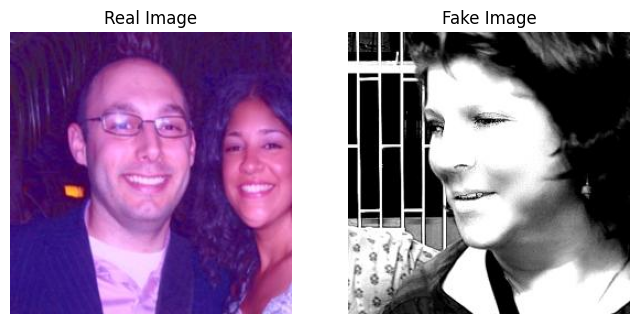

Real Image classified as: Real
Fake Image classified as: Fake


In [ ]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# ----- Set device -----
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ----- Transform -----
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# ----- Load Trained Models -----
# Autoencoder
class SupervisedAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(SupervisedAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # (B, 32, H/2, W/2)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # (B, 64, H/4, W/4)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # (B, 128, H/8, W/8)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*16*16, latent_dim)
        )
        
        # Classifier head
        self.classifier = nn.Linear(latent_dim, 2)  # real/fake
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128*16*16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    
            nn.Sigmoid()
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        class_logits = self.classifier(latent)
        
        x_recon = self.decoder_fc(latent)
        x_recon = x_recon.view(-1, 128, 16, 16)
        x_recon = self.decoder(x_recon)
        
        return x_recon, class_logits, latent

autoencoder = SupervisedAutoencoder().to(device)
autoencoder.load_state_dict(torch.load("supervised_autoencoder.pth", map_location=device))
autoencoder.eval()

# Classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=128):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.net(x)

mlp_model = MLPClassifier().to(device)
mlp_model.load_state_dict(torch.load("mlp_classifier.pth", map_location=device))  # Replace with correct path
mlp_model.eval()

# ----- Load One Real and One Fake Image -----
real_image_path = "dataset/DataSet1/test/real/real_47.jpg"  # Replace with actual path
fake_image_path = "dataset/DataSet1/test/fake/fake_5403.jpg"  # Replace with actual path

real_img = Image.open(real_image_path).convert("RGB")
fake_img = Image.open(fake_image_path).convert("RGB")

# Display the images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(real_img)
plt.title("Real Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(fake_img)
plt.title("Fake Image")
plt.axis("off")
plt.show()

# ----- Preprocess -----
real_tensor = transform(real_img).unsqueeze(0).to(device)
fake_tensor = transform(fake_img).unsqueeze(0).to(device)

# ----- Extract Features -----
with torch.no_grad():
    _, _, real_latent = autoencoder(real_tensor)
    _, _, fake_latent = autoencoder(fake_tensor)

# ----- Classify -----
with torch.no_grad():
    real_pred = mlp_model(real_latent).argmax(dim=1).item()
    fake_pred = mlp_model(fake_latent).argmax(dim=1).item()

# ----- Print Results -----
label_map = {0: "Real", 1: "Fake"}
print(f"Real Image classified as: {label_map[real_pred]}")
print(f"Fake Image classified as: {label_map[fake_pred]}")


## Quality of Reconstruction

/tmp/ipykernel_3037637/108405554.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


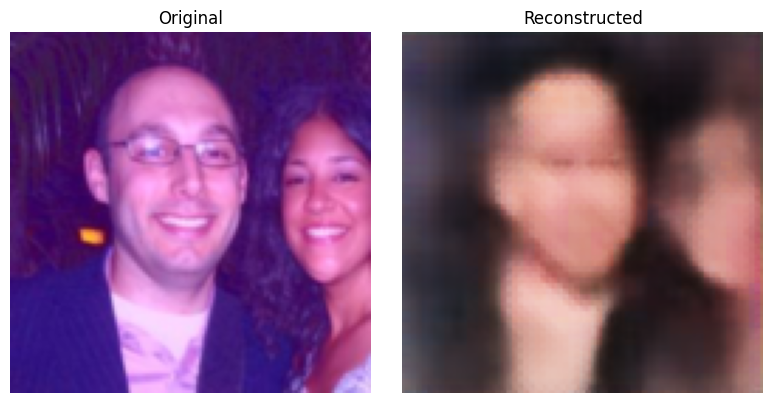

In [12]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# from model import SupervisedAutoencoder  # Import your model class

# Config
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model_path = "supervised_autoencoder.pth"
image_path = "dataset/DataSet1/test/real/real_47.jpg"

# Load model
model = SupervisedAutoencoder(latent_dim=128).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load and preprocess image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Inference
with torch.no_grad():
    recon_tensor, _, _ = model(input_tensor)

# Convert tensors to numpy arrays for display
original_np = input_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
reconstructed_np = recon_tensor.squeeze().cpu().permute(1, 2, 0).numpy()

# Plot original and reconstructed
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed")
plt.imshow(reconstructed_np)
plt.axis('off')

plt.tight_layout()
plt.show()
